# Machine Learning using Sentinel-2 Data

This example uses training data from the
[Coast Train](https://github.com/nick-murray/coastTrain) dataset
along with Sentinel-2 data to demonstrate how to use a
machine learning classifier, in this case, Random Forest, to
assign a class to each pixel.

This notebook combines lessons from previous notebooks into
a comprehensive worked example.

## Getting started

First we load the required Python libraries and tools.

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from ldn.typology import colors, classes as classes_values
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


## Training data

Load it.

In [ ]:
# Get the training data
training_data = gpd.read_file("training_data.geojson")
class_attr = "lulc"

training_data.explore(
    column=class_attr,
    categorical=True,
    categories=(present_classes := sorted(training_data[class_attr].unique())),
    cmap=[colors[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)

In [28]:
# Remove geometry column for train/test split
training_data = training_data.drop(columns="geometry")

print(len(training_data))

# Split 70/30 into train/test. Splits the classes into train/test in a representative way.
train_gdf, test_gdf = train_test_split(training_data, test_size=0.3, stratify=training_data[class_attr], random_state=42)

print(f"Training set class distribution:\n{train_gdf[class_attr].value_counts()}")
print(f"Test set class distribution:\n{test_gdf[class_attr].value_counts()}")
print(train_gdf)

2264
Training set class distribution:
lulc
7    650
5    234
6    140
3    140
4    140
1    140
2    140
Name: count, dtype: int64
Test set class distribution:
lulc
7    279
5    101
2     60
3     60
6     60
4     60
1     60
Name: count, dtype: int64
      lulc     nir08       red    swir22       emad      smad    swir16  \
1858     6  0.282652  0.212610  0.281140  6109.8418  0.001039  0.296155   
1713     6  0.311858  0.140340  0.188190  2976.4541  0.000740  0.252320   
1679     6  0.195395  0.169352  0.156400  2248.0786  0.000236  0.190445   
443      7  0.002152  0.007488  0.011723   829.3056  0.000478  0.011860   
480      7  0.013290  0.017827  0.013593  1560.4281  0.000511  0.016095   
...    ...       ...       ...       ...        ...       ...       ...   
1791     6  0.172460  0.076320  0.113555  1907.9551  0.001344  0.169325   
1996     4  0.184202  0.030560  0.037435  1240.1238  0.000701  0.078740   
754      7  0.014995  0.012547  0.015050  1378.0406  0.000954  0.01711

## Create a classifier and fit a model

We pass in simple numpy arrays to the classifier, one has the
observations (the values of the red, green, blue and so on)
while the other has the classes.

In [ ]:
# The classes are the first column
classes = np.array(train_gdf)[:, 0]
print(f"Classes: {classes}")

# The observation data is everything after the first column
observations = np.array(train_gdf)[:, 1:]

# Create a model...
classifier = RandomForestClassifier(class_weight='balanced')

# ...and fit it to the data
model = classifier.fit(observations, classes)

Classes: [6. 6. 6. ... 7. 3. 7.]


In [ ]:
# Define features and target

feature_cols = [c for c in train_gdf.columns if c != class_attr]

low_importance = ["smad", "bcmad", "emad", "blue", "ln_bg", "bg"]
feature_cols_reduced = [f for f in feature_cols if f not in low_importance]

X_train = train_gdf[feature_cols_reduced].values
y_train = train_gdf[class_attr].values
X_test = test_gdf[feature_cols_reduced].values
y_test = test_gdf[class_attr].values

classifier = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Feature importance — drop noisy features
importances = pd.Series(model.feature_importances_, index=feature_cols_reduced).sort_values(ascending=False)
print("Feature importances:")
print(importances)
# Feature importance is probably the most useful next step — it'll tell you which bands are actually helping and which are adding noise.

target_names = [k for k, v in sorted(classes_values.items(), key=lambda x: x[1]) if v != 0]

print(classification_report(y_test, y_pred, target_names=target_names))

Feature importances:
elevation    0.096742
nir08        0.090292
ndwi         0.084088
swir22       0.079332
swir16       0.073823
baei         0.070660
mbi          0.069578
mndwi        0.068738
red          0.065077
bui          0.063542
green        0.060550
bsi          0.059359
ndvi         0.059258
ndti         0.058961
dtype: float64
              precision    recall  f1-score   support

  Tree Cover       0.68      0.60      0.64        60
   Grassland       0.57      0.52      0.54        60
    Cropland       0.33      0.33      0.33        60
     Wetland       0.83      0.90      0.86        60
    Built-up       0.54      0.70      0.61       101
       Other       0.45      0.28      0.35        60
       Water       0.99      0.98      0.98       279

    accuracy                           0.74       680
   macro avg       0.63      0.62      0.62       680
weighted avg       0.74      0.74      0.73       680



In [36]:
# geomad_dem=xr.open_dataset('geomad_dem.tif',engine="rasterio").astype(np.uint8).to_array().squeeze()
geomad_dem = xr.open_dataset("geomad_dem.nc")

stack = np.stack([geomad_dem[f].values.flatten() for f in feature_cols], axis=1)
stack = np.stack([geomad_dem[f].values.flatten() for f in feature_cols_reduced], axis=1)
stack = np.nan_to_num(stack, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

predictions = model.predict(stack)

# Reshape back to raster
prediction_map = predictions.reshape(geomad_dem[feature_cols_reduced[0]].shape)

# Wrap in DataArray
predicted_da = xr.DataArray(
    prediction_map,
    coords={"y": geomad_dem.y, "x": geomad_dem.x},
    dims=["y", "x"],
    name="lulc",
)

## Visualise our results


In [ ]:
from matplotlib.colors import ListedColormap

from odc.geo.xr import assign_crs

predicted_da = assign_crs(predicted_da, crs="EPSG:6933")

present_classes = sorted(np.unique(predicted_da.values).tolist())
cmap = ListedColormap([colors[c] for c in present_classes])

predicted_da.odc.explore(cmap=cmap, legend=True)

              precision    recall  f1-score   support

  Tree Cover       0.68      0.60      0.64        60
   Grassland       0.57      0.52      0.54        60
    Cropland       0.33      0.33      0.33        60
     Wetland       0.83      0.90      0.86        60
    Built-up       0.54      0.70      0.61       101
       Other       0.45      0.28      0.35        60
       Water       0.99      0.98      0.98       279

    accuracy                           0.74       680
   macro avg       0.63      0.62      0.62       680
weighted avg       0.74      0.74      0.73       680



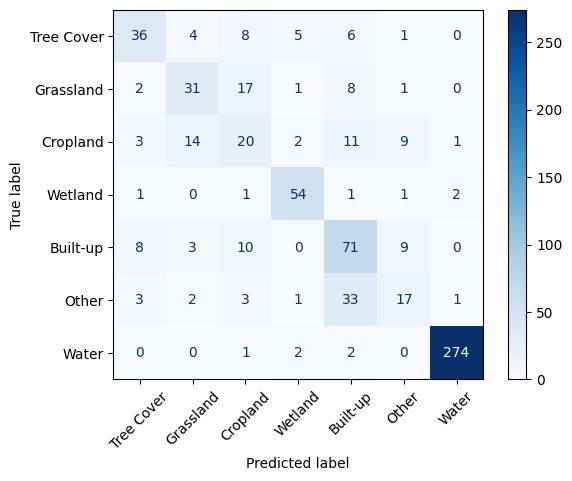

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = [k for k, v in sorted(classes_values.items(), key=lambda x: x[1]) if v != 0]

# Classification report
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45, cmap="Blues")